### Connect to the google drive

In [1]:
import os, sys
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Save packages in Google Drive to speed up future code runs in Colab. 

In [4]:
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)
!pip install --target=$nb_path torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install --target=$nb_path torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install --target=$nb_path torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install --target=$nb_path torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install --target=$nb_path torch-geometric
!pip install --target=$nb_path torch-geometric-temporal

### Reading saved packages in google drive

In [2]:
# Importing libraries
from google.colab import drive
import sys, os
# Mount google drive
drive.mount('/content/drive', force_remount=True)
# Changing path dirctory
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


In [3]:
from datetime import datetime
import geopy.distance
import glob
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn import STConv
from tqdm import tqdm

In [4]:
class FullyConnLayer(nn.Module):
    def __init__(self, c):
        super(FullyConnLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation = 1, padding = (0,0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation = 1, padding = (0,0))
        self.fc = FullyConnLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)

        return self.fc(x_t2)

class TrafficModel(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers,
                 kernel_size, K, window_size, \
                 normalization = 'sym', bias = True):

        super(TrafficModel, self).__init__()
        self.layers = nn.ModuleList([])
        for l in range(num_layers):
            input_size, hidden_size, output_size = \
            channel_size_list[l][0], channel_size_list[l][1], \
            channel_size_list[l][2]
            self.layers.append(STConv(num_nodes, input_size, hidden_size, \
                                      output_size, kernel_size, K, \
                                      normalization, bias))
        self.layers.append(OutputLayer(channel_size_list[-1][-1], \
                                       window_size - 2 * num_layers * (kernel_size - 1), \
                                       num_nodes))
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight):
        for layer in self.layers[:-1]:
          x = layer(x, edge_index, edge_weight)
        out_layer = self.layers[-1]
        x = x.permute(0, 3, 1, 2)
        x = out_layer(x)
        return x

In [6]:
channels = np.array([[1, 4, 8], [8, 4, 8]])

kernel_size = 3
K = 3

learning_rate = 0.01
batch_size = 10
num_epochs = 20
num_layers = 1
n_his = 20

n_pred = 5

train_prop = 0.7
val_prop = 0.2
test_prop = 0.1

model_save_path = os.path.join(
    'drive', 'MyDrive', 'best_model.pt')

In [7]:
def data_transform(data, n_his, n_pred, device):

    num_nodes = data.shape[1]
    num_obs = len(data) - n_his - n_pred
    x = np.zeros([num_obs, n_his, num_nodes, 1])
    y = np.zeros([num_obs, num_nodes])

    obs_idx = 0
    for i in range(num_obs):
        head = i
        tail = i + n_his
        x[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        y[obs_idx] = data[tail + n_pred - 1]
        obs_idx += 1

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

In [8]:
weighted_adj_matrix_path = os.path.join('/content/drive/MyDrive/GBDS_Data_new/processed_data/distances.csv')
W = pd.read_csv(weighted_adj_matrix_path).drop('station_id', axis=1)

feature_vectors_path = os.path.join('/content/drive/MyDrive/GBDS_Data_new/processed_data/combined.csv')
V = pd.read_csv(feature_vectors_path).drop('time', axis=1)

In [9]:
for pos, col in enumerate(W.columns):
  if col != V.columns[pos]:
    print(col, V.columns[pos])

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() \
else torch.device("cpu")

In [11]:
num_samples, num_nodes = V.shape

len_train = round(num_samples * train_prop)
len_val = round(num_samples * val_prop)
train = V[ : len_train]
val = V[len_train : len_train + len_val]
test = V[len_train + len_val : len_train + len_val + round(num_samples * test_prop)]

scaler = StandardScaler()
train = np.nan_to_num(scaler.fit_transform(train))
val = np.nan_to_num(scaler.transform(val))
test = np.nan_to_num(scaler.transform(test))

x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

G = sp.coo_matrix(W)
edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
edge_weight = torch.tensor(G.data).float().to(device)

In [12]:
model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [13]:
def evaluate_model(model, loss, data_iter, edge_index, edge_weight, device):
  model.eval()
  l_sum, n = 0.0, 0
  with torch.no_grad():
      for x, y in data_iter:
          y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
          l = loss(y_pred, y)
          l_sum += l.item() * y.shape[0]
          n += y.shape[0]
      return l_sum / n

def evaluate_metric(model, data_iter, scaler, edge_index, edge_weight, device):
    model.eval()
    epsilon = 1e-6
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x.to(device), \
                                                    edge_index, \
                                                    edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / (y+epsilon)).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE

In [14]:
min_val_loss = np.inf
for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch', position = 0):
  l_sum, n = 0.0, 0

  model.train()

  for x, y in tqdm(train_iter, desc = 'Batch', position = 0):

    y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
    l = loss(y_pred, y)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    l_sum += l.item() * y.shape[0]
    n += y.shape[0]

  val_loss = evaluate_model(model, loss, val_iter, edge_index, edge_weight, device)
  if val_loss < min_val_loss:
      min_val_loss = val_loss
      torch.save(model.state_dict(), model_save_path)
  print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

Epoch:   5%|▌         | 1/20 [04:37<1:27:47, 277.23s/it]

epoch 1 , train loss: 0.885272982707465 , validation loss: 1.100475556383568


Epoch:  10%|█         | 2/20 [09:12<1:22:54, 276.34s/it]

epoch 2 , train loss: 0.8075168418071762 , validation loss: 1.0856938211410219


Epoch:  15%|█▌        | 3/20 [13:48<1:18:11, 275.98s/it]

epoch 3 , train loss: 0.7800958882391998 , validation loss: 1.053093674574968


Epoch:  20%|██        | 4/20 [18:24<1:13:34, 275.88s/it]

epoch 4 , train loss: 0.770401157052204 , validation loss: 1.0530492713242883


Epoch:  25%|██▌       | 5/20 [22:59<1:08:55, 275.71s/it]

epoch 5 , train loss: 0.7566852907925875 , validation loss: 1.028607704000328


Epoch:  30%|███       | 6/20 [27:35<1:04:19, 275.65s/it]

epoch 6 , train loss: 0.7544601373488153 , validation loss: 1.0367127727759655


Epoch:  35%|███▌      | 7/20 [32:10<59:42, 275.60s/it]  

epoch 7 , train loss: 0.7507930854572284 , validation loss: 1.014890693269755


Epoch:  40%|████      | 8/20 [36:45<55:06, 275.50s/it]

epoch 8 , train loss: 0.7524482244028807 , validation loss: 1.0384847084379014


Epoch:  45%|████▌     | 9/20 [41:21<50:30, 275.49s/it]

epoch 9 , train loss: 0.7464503644684203 , validation loss: 1.0222962482800502


Epoch:  50%|█████     | 10/20 [45:56<45:54, 275.42s/it]

epoch 10 , train loss: 0.7422234529396282 , validation loss: 1.0226255510243172


Epoch:  55%|█████▌    | 11/20 [50:32<41:20, 275.56s/it]

epoch 11 , train loss: 0.7424393937158439 , validation loss: 0.9998890423276126


Epoch:  60%|██████    | 12/20 [55:07<36:44, 275.52s/it]

epoch 12 , train loss: 0.740083858476893 , validation loss: 1.0230504132722267


Epoch:  65%|██████▌   | 13/20 [59:43<32:08, 275.52s/it]

epoch 13 , train loss: 0.733944718617025 , validation loss: 1.0124224834569053


Epoch:  70%|███████   | 14/20 [1:04:18<27:32, 275.46s/it]

epoch 14 , train loss: 0.7343367728369646 , validation loss: 0.9857979808923409


Epoch:  75%|███████▌  | 15/20 [1:08:54<22:57, 275.41s/it]

epoch 15 , train loss: 0.7326363973008774 , validation loss: 1.0020054449033375


Epoch:  80%|████████  | 16/20 [1:13:29<18:21, 275.48s/it]

epoch 16 , train loss: 0.7323496614564835 , validation loss: 0.9865458669997893


Epoch:  85%|████████▌ | 17/20 [1:18:05<13:46, 275.45s/it]

epoch 17 , train loss: 0.7278835949007638 , validation loss: 1.0049608758873814


Epoch:  90%|█████████ | 18/20 [1:22:40<09:11, 275.53s/it]

epoch 18 , train loss: 0.7292744086208324 , validation loss: 0.968180794396328


Epoch:  95%|█████████▌| 19/20 [1:27:16<04:35, 275.48s/it]

epoch 19 , train loss: 0.7287225251522821 , validation loss: 0.9716264882015184


Epoch: 100%|██████████| 20/20 [1:31:51<00:00, 275.58s/it]

epoch 20 , train loss: 0.7278472162093418 , validation loss: 0.9785321402459091


In [15]:
best_model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)
best_model.load_state_dict(torch.load(model_save_path))

l = evaluate_model(best_model, loss, test_iter, edge_index, edge_weight, device)
MAE, MAPE, RMSE = evaluate_metric(best_model, test_iter, scaler, edge_index, edge_weight, device)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

test loss: 1.1974361959625692 
MAE: 1.6890731541187558 , MAPE: 323013.805631974 , RMSE: 2.9795492169340374


In [16]:
predict_model = best_model

pred_save_path = os.path.join(
    'drive', 'MyDrive',  'predictions_testing.csv')

In [17]:
def get_predictions(model, pred_iter, scaler, edge_index, edge_weight, num_nodes, device):
    model.eval()
    with torch.no_grad():
      for x, y in pred_iter:
        y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
        y_pred = scaler.inverse_transform(model(x.to(device), \
                                                edge_index, \
                                                edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
        y_pred = y_pred.reshape(-1, num_nodes)

      return y, y_pred

In [18]:
pred_len = 144

pred_set = V[(-pred_len - n_his - n_pred):]
pred_set = np.nan_to_num(scaler.transform(pred_set))
x_pred, y_pred = data_transform(pred_set, n_his, n_pred, device)
pred_data = torch.utils.data.TensorDataset(x_pred, y_pred)
pred_iter = torch.utils.data.DataLoader(pred_data, pred_len + n_his + n_pred + 1)

predictions = get_predictions(predict_model, pred_iter, scaler, edge_index, edge_weight, 1836, device)
np.savetxt(pred_save_path, predictions[1], delimiter=',')

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

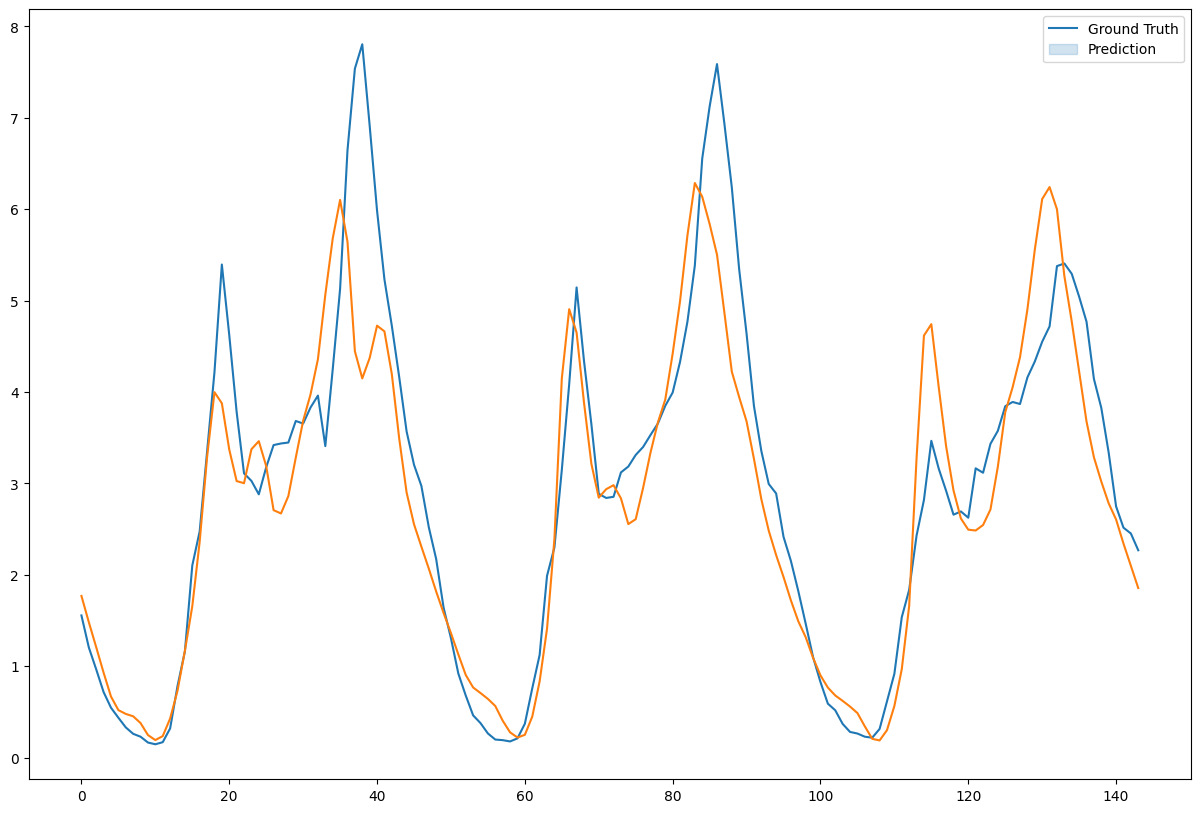

In [20]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.lineplot(y=summed_test_truth, x=range(len(summed_test_preds)))
sns.lineplot(y=summed_test_preds, x=range(len(summed_test_preds)))
plt.legend(labels=['Ground Truth', 'Prediction']);

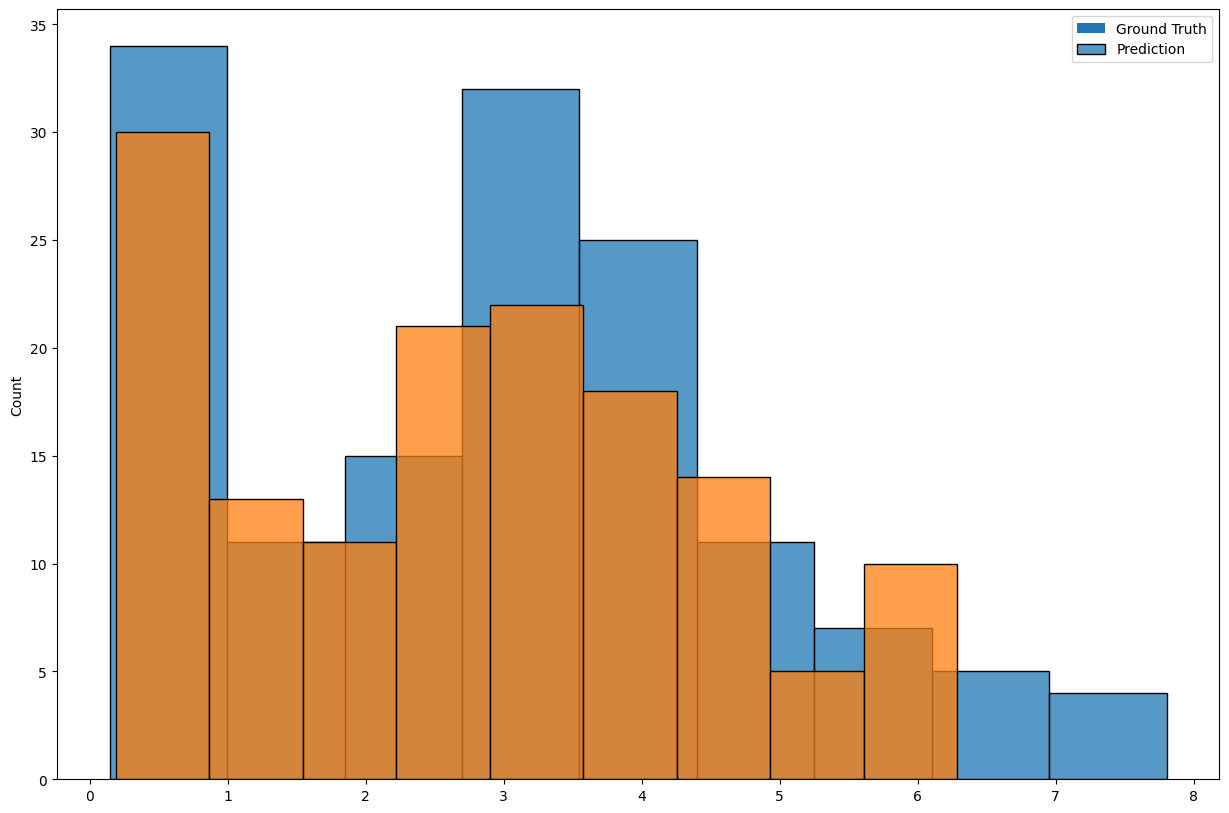

In [21]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction']);

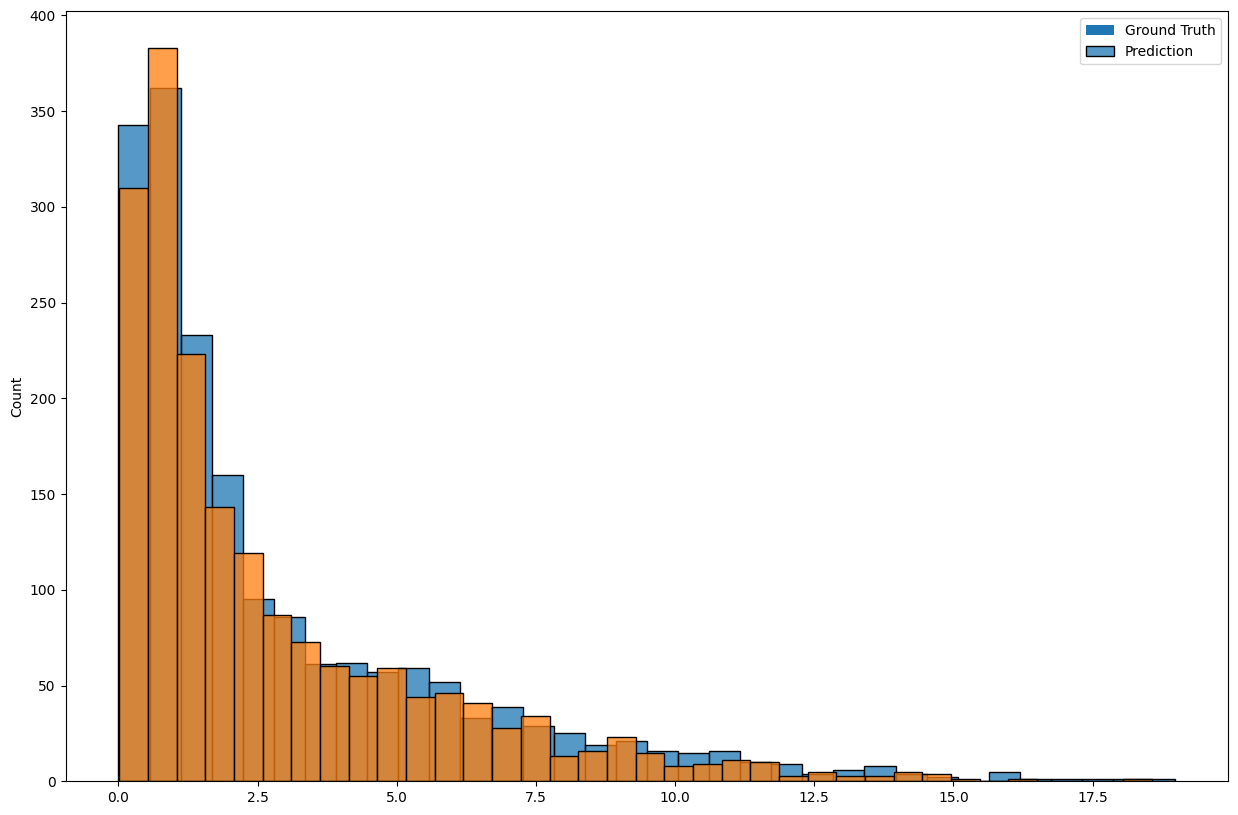

In [22]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=0)
summed_test_preds = test_preds.mean(axis=0)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction']);